In [79]:
from __future__ import print_function
from datahandling import access_db, get_equip_names, get_dtype_names
from tinydb import Query
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from time import time
from pandas import DataFrame
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from numpy import cumsum
% matplotlib inline

In [2]:
db_X = access_db(3, True)

In [3]:
sv_db = access_db(0, True)

In [4]:
# db_X.purge()

In [5]:
Q = Query()

In [6]:
ingredients = ['PVC', 'filler', 'FR', 'stabiliser', 'DINP', 'LDH', 'spherical_filler']

In [7]:
equip_names = get_equip_names(sv_db)
equip_names

[u'colour', u'LOI', u'MCC', u'thermomat', u'tensile', u'rheomix', u'ConeCal']

In [8]:
sv_db.remove((Q.sample_number == 35))

[]

Populate X from single value database and store in new db

In [9]:
X = []
tm = time()
d_types_skip = ['epsilon_break_%', 
                'epsilon_max_%', 
                'sigma_break_MPa', 
                'sigma_max_MPa', 
                'E_t_MPa',
                'int_of_abs_err'
               ]

if not db_X.all():
    d_type_descr = []
    for sample_no in range(53):
        sample_no += 1
        
        if sample_no == 35:
            continue
        
        data_p_sample = []

        for ing in ingredients:
            entry = sv_db.search((Q.sample_number == sample_no) &
                                 (Q.ingredient == ing))
            val = entry[0]['value']
            data_p_sample.append(val)
            
            if sample_no == 1:
                d_type_descr.append('MassFrac ' + ing) 

        for en in equip_names:
            d_type_names = get_dtype_names(sv_db, en)
            d_type_names = [i for i in d_type_names if i not in d_types_skip]
            for dtn in d_type_names:
                entry = sv_db.search((Q.sample_number == sample_no) &
                                     (Q.equipment_name == en) &
                                     (Q.data_type == dtn))

                if entry:
                    val = entry[0]['value']
                else:
                    val = None

                data_p_sample.append(val)
                
                if sample_no == 1:
                    d_type_descr.append(en + ' ' + dtn)

        X.append(data_p_sample)
    
    entry = {'X': X,
             'd_type_descr': d_type_descr}
    db_X.insert(entry)

req_time = time() - tm
print(req_time)

0.0


Database has missing values, missing values can either be replaced by mean or the incomplete rows are excluded from X

In [56]:
X = db_X.all()[0]['X']
impute = False
if impute:
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imp.fit(X)
    X = imp.transform(X)
else:
    # Removing all incomplete samples
    X = [sample for sample in X if None not in sample]

Do PCA

In [57]:
X_std = StandardScaler().fit_transform(X)

In [58]:
len(X_std[0])

41

In [59]:
my_pca = PCA(n_components=41)

In [60]:
my_pca.fit(X_std)

PCA(copy=True, n_components=41, whiten=False)

Analyse PCA results by looking at principal components with highest explained variance

In [61]:
comp = my_pca.components_

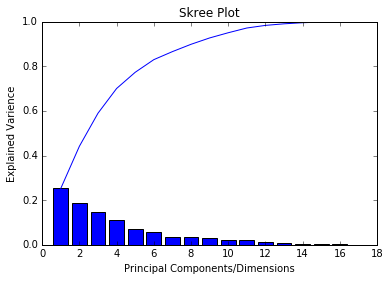

In [90]:
exp_var = my_pca.explained_variance_ratio_
plt.bar([i + 1 for i in range(len(exp_var))], exp_var, 0.8, align='center')
plt.plot([i + 1 for i in range(len(exp_var))], cumsum(exp_var))
plt.title('Skree Plot')
plt.xlabel('Principal Components/Dimensions')
plt.ylabel('Explained Varience')

In [64]:
descr = db_X.all()[0]['d_type_descr']

In [65]:
comp = [list(c) for c in comp]

In [66]:
d = [descr] + comp

In [67]:
df = DataFrame(data=d).T

Is this the decomposition matrix?

In [91]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,MassFrac PVC,0.00874475,-0.328204,-0.0428546,0.0801673,-0.0622125,0.149806,-0.0136151,-0.109321,0.152912,-0.0901108,0.0391042,-0.0778875,0.0272779,-0.00194141,0.0467538,-0.245319,-0.211101
1,MassFrac filler,0.113603,0.243047,-0.0597099,-0.0562856,0.253094,-0.153452,0.102865,-0.057124,-0.0949447,0.106473,-0.298993,-0.0611367,0.114285,0.110145,-0.0215447,0.0697938,-0.156601
2,MassFrac FR,0.0933445,0.00320204,0.339134,-0.029282,-0.151549,0.163472,-0.0356382,0.0669074,-0.178913,-0.0713391,0.0796922,0.021215,-0.0479018,-0.10638,-0.17253,0.405756,-0.0577427
3,MassFrac stabiliser,0.0106886,-0.237362,-0.0732321,0.049242,-0.249127,0.0213257,-0.0820935,-0.217775,-0.402764,0.217961,0.0617218,0.0472605,0.222283,0.176176,0.0298312,0.00760336,0.303951
4,MassFrac DINP,-0.289211,0.0113458,0.123279,-0.0454695,-0.00630027,0.0797343,0.000738312,-0.0147399,0.019621,0.0637526,0.077908,0.0751284,-0.0638901,-0.0629897,0.0540606,-0.0788641,-0.210899
5,MassFrac LDH,-0.02389,0.0980447,-0.237251,-0.156178,-0.269787,0.143291,-0.211051,0.121397,0.0221201,0.0441754,0.261778,-0.159802,-0.303168,-0.263759,0.108646,0.114013,-0.353322
6,MassFrac spherical_filler,0.0344618,0.0303524,-0.0456543,0.218789,-0.0205517,-0.354675,0.0205974,0.347518,0.286433,-0.283395,0.271913,0.335945,-0.0486274,0.0774743,-0.0561907,-0.10143,0.195795
7,colour YI,0.0858895,0.141589,-0.224103,-0.17095,-0.0442055,0.235474,-0.127885,-0.076063,0.166396,-0.246853,0.255151,-0.164536,0.00467471,-0.0810833,0.0841353,-0.150805,0.396998
8,LOI Final,0.260714,-0.0889444,0.114892,0.0561183,-0.170238,0.0652219,-0.0374005,0.118961,-0.0729794,-0.0280374,-0.0790596,-0.0849572,-0.0139776,-0.0257748,-0.231064,0.0733302,0.142473
9,MCC t_HR_kJpg,-0.246594,-0.111112,0.0302263,-0.143036,0.197917,-0.0280589,0.158966,-0.0502749,-0.0155727,-0.00928028,-0.0461766,0.0930259,-0.0228458,-0.213301,0.00611459,-0.103025,0.186795


In [69]:
prin_comp = 1
top = 5
sort_df = df.reindex(df[prin_comp].abs().sort_values(ascending=False).index)
clipped_df = sort_df.head(n=top)[[0, prin_comp]]
clipped_df

,0,1
16,MCC t_HR_peak_1_kJpg,-0.296511
4,MassFrac DINP,-0.289211
23,tensile epsilon_break_%_mean,-0.281056
26,tensile epsilon_max_%_mean,-0.278876
8,LOI Final,0.260714


In [70]:
names = clipped_df[0].tolist()

In [71]:
names

[u'MCC t_HR_peak_1_kJpg',
 u'MassFrac DINP',
 u'tensile epsilon_break_%_mean',
 u'tensile epsilon_max_%_mean',
 u'LOI Final']

In [72]:
df_2 = DataFrame(data=X_std, columns=descr)[names]

[[None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None],
 [None]]

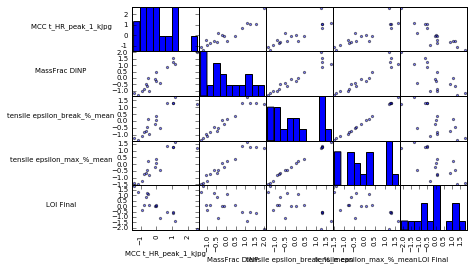

In [73]:
Axes = scatter_matrix(df_2)#, diagonal='kde')
n = len(df_2.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = Axes[x, y]
        # to make x axis name vertical  
#         ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

size = 7
[plt.setp(item.yaxis.get_majorticklabels(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.xaxis.get_majorticklabels(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.xaxis.get_label(), 'size', size) for item in Axes.ravel()]
[plt.setp(item.yaxis.get_label(), 'size', size) for item in Axes.ravel()]